# Tabular Q-learning

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from collections import defaultdict
import random
import math
import numpy as np

class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!z
        Note: please avoid using self._qvalues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V^*(s) using current q-values
        V^*(s) = max_{over_action} Q^*(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value = max(self.get_qvalue(state, action) for action in possible_actions)

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        old_q = self.get_qvalue(state, action)
        upd = reward + gamma * self.get_value(next_state)
        #new_q = (1 - self.alpha) * old_q + self.alpha * upd
        new_q = old_q - learning_rate * (old_q - upd)
        
        self.set_qvalue(state, action, new_q)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        best_action = max(possible_actions, key=lambda action: self.get_qvalue(state, action))

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon
        
        best_action = self.get_best_action(state)
        random_action = np.random.choice(possible_actions)
        
        chosen_action = random_action if np.random.rand() < epsilon else best_action

        return chosen_action

# Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [ ]:
import gym
env = gym.make("Taxi-v3")

n_actions = env.action_space.n

In [ ]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))

In [ ]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

eps = 2.9191091959171894e-05 mean reward = 5.8


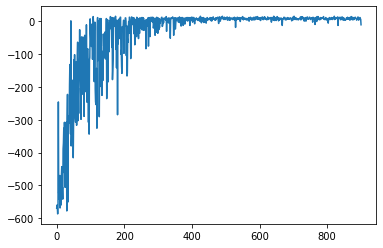

In [ ]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()


# On-policy learning and SARSA

This notebook builds upon qlearning.ipynb, or to be exact, generating qlearning.py.

The policy we're gonna use is epsilon-greedy policy, where agent takes optimal action with probability $(1-\epsilon)$, otherwise samples action at random. Note that agent can occasionally sample optimal action during random sampling by pure chance.


In [ ]:
class EVSarsaAgent(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        
        #value = max(self.get_qvalue(state, action) for action in possible_actions)

        best_action = self.get_best_action(state)
        best_q = self.get_qvalue(state, best_action)

        random_qs = np.array([self.get_qvalue(state, action) for action in possible_actions])
        value = (random_qs * epsilon / len(possible_actions)).sum() + (1 - epsilon) * best_q
        
        return value


# Cliff's World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>


In [ ]:
import gym
import gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__)
env.render()


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



Our cliffworld has one difference from what's on the image: there is no wall.

Agent can choose to go as close to the cliff as it wishes. x:start, T:exit, C:cliff, o: flat ground

In [ ]:
agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.05, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.05, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

EVSARSA mean reward = -16.02
QLEARNING mean reward = -20.99


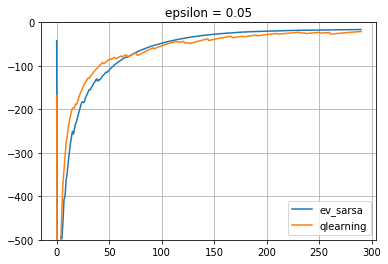

In [ ]:
from IPython.display import clear_output
from pandas import DataFrame


def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values


rewards_sarsa, rewards_ql = [], []

for i in range(300):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 10 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = {}".format(agent_ql.epsilon))
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [ ]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [ ]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("EVSARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 >  ^  >  >  ^  >  >  >  >  ^  >  v 
 ^  >  ^  >  >  >  v  v  >  v  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
EVSARSA
 ^  >  >  ^  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  ^  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


# More on SARSA

Here are some of the things you can do if you feel like it:

* Play with epsilon. See learned how policies change if you set epsilon to higher/lower values (e.g. 0.75).
* Expected Value SASRSA for softmax policy: $$ \pi(a_i|s) = softmax({Q(s,a_i) \over \tau}) = {e ^ {Q(s,a_i)/ \tau} \over {\sum_{a_j} e ^{Q(s,a_j) / \tau }}} $$
* Implement N-step algorithms and TD($\lambda$): see [Sutton's book](http://incompleteideas.net/book/bookdraft2018jan1.pdf) chapter 7 and chapter 12: 
* Use those algorithms to train on CartPole in previous / next assignment for this week.

In [ ]:
from scipy.special import softmax
class TauQLearningAgent(QLearningAgent):
    
    def __init__(self, alpha, epsilon, discount, get_legal_actions, tau):
        super().__init__(alpha, epsilon, discount, get_legal_actions)
        self.tau = tau
    
    def get_action(self, state):
        
        possible_actions = self.get_legal_actions(state)
        
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        
        probs = softmax([self.get_qvalue(state, action) / self.tau for action in possible_actions])
        chosen_action = np.random.choice(possible_actions, p=probs)

        return chosen_action

In [ ]:
class TauEVSarsaAgent(TauQLearningAgent):
    
    def get_value(self, state):
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        
        qvals = np.array([self.get_qvalue(state, action) for action in possible_actions])
        probs = softmax(qvals / self.tau)
        value = (qvals * probs).sum()
        
        return value

In [ ]:
agent_tsarsa = TauEVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                        get_legal_actions=lambda s: range(n_actions), tau=0.5)

agent_tql = TauQLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                        get_legal_actions=lambda s: range(n_actions), tau=0.5)

Remember, that in deterministic way with epsilon=0 and tau->0, both versions (epsilon and tau) of the algorithms work equal and return -13 points. In this environment there is no sufficient difference in quality between epsilon-greedy and tau-softmax

TAU EVSARSA mean reward = -13.94
TAU QLEARNING mean reward = -16.35


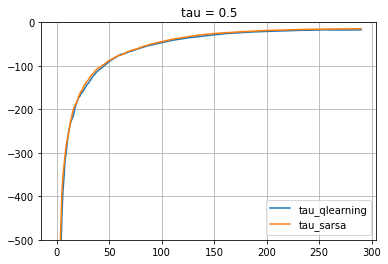

In [ ]:
rewards_tql, rewards_tsarsa = [], []

for i in range(300):
    rewards_tql.append(play_and_train(env, agent_tql))
    rewards_tsarsa.append(play_and_train(env, agent_tsarsa))
    # Note: agent.tau stays constant

    if i % 10 == 0:
        clear_output(True)
        print('TAU EVSARSA mean reward =', np.mean(rewards_tsarsa[-100:]))
        print('TAU QLEARNING mean reward =', np.mean(rewards_tql[-100:]))
        plt.title("tau = {}".format(agent_tql.tau))
        plt.plot(moving_average(rewards_tql), label='tau_qlearning')
        plt.plot(moving_average(rewards_tsarsa), label='tau_sarsa')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

In [ ]:
print("Tau Q-Learning")
draw_policy(env, agent_tql)

print("TAU EVSARSA")
draw_policy(env, agent_tsarsa)

Tau Q-Learning
 >  >  >  >  >  >  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
TAU EVSARSA
 >  >  >  >  >  >  >  >  >  >  v  v 
 >  >  v  v  v  >  v  >  v  v  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
